In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
'''
- Pega o diretório do dataset até o número da sequência
- Procura pelo subdiretório velodyne para retirar o .bin do frame
- Transforma os dados do .bin em uma matriz bidimensional
- Pega cada ponto do .bin e concatena a uma lista e retorna
'''

def load_semantic_kitti_data(sequence_path, frame_number):
    point_cloud = []
    
    velodyne_path = os.path.join(sequence_path, 'velodyne')

    file_name = f"{frame_number:06d}.bin"
    file_path = os.path.join(velodyne_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            points = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

            coordinates = points[:, :4]

            point_cloud.append(coordinates)
    else:
        print(f"Arquivo {file_name} não encontrado no diretório 'velodyne' da sequência.")
    if not point_cloud:
        print("Nenhum dado encontrado para o frame especificado.")
        
    point_cloud = np.concatenate(point_cloud, axis=0)

    return point_cloud

In [76]:
point_cloud

array([[78.566666 ,  7.0999002,  2.8758585,  0.       ],
       [78.527176 ,  7.344794 ,  2.8758185,  0.       ],
       [64.04665  ,  6.595122 ,  2.3858511,  0.15     ],
       ...,
       [ 3.710243 , -1.3863789, -1.7032311,  0.34     ],
       [ 3.7247083, -1.378382 , -1.7082465,  0.29     ],
       [ 3.7382305, -1.3713849, -1.71326  ,  0.       ]], dtype=float32)

In [69]:
len(point_cloud)

112898

In [77]:
'''
- Para a projeção esférica são lidos as coordenadas x,y,z de cada ponto
- R é a distância do laser até a origem (LiDAR)
- desvio_eixoY é o valor no plano xy e o ângulo com range de [FOV_UP, FOV_DOWN] para max/min
- desvio_eixoX é o valor no plano xz com range de [-pi,pi] por causa da função arctan2
- É necessário normalizar os desvios para pegar os pontos na distorção para 2D
- Como o modelo do LiDAR utilizado é o Velodyne HDL 64-E, a imagem deve ser 64x1024
- Retorna o ponto (u,v, intensidade) da projeção
'''
def spherical_projection(point_cloud):
    x_coord = point_cloud[:, 0]
    y_coord = point_cloud[:, 1]
    z_coord = point_cloud[:, 2]

    R = np.sqrt(x_coord**2 + y_coord**2 + z_coord**2)

    desvio_eixoY = np.arcsin(z_coord/R)
    desvio_eixoX = np.arctan2(y_coord, x_coord)

    FOV_UP = np.max(desvio_eixoY)
    FOV_DOWN = np.min(desvio_eixoY)
    FOV = FOV_UP + abs(FOV_DOWN)

    normal_Y = 1.0 - ((desvio_eixoY + abs(FOV_DOWN))/FOV)
    normal_X = 0.5 * ((desvio_eixoX/np.pi) + 1)
    
    return normal_Y*64, normal_X*1024, point_cloud[:, 3]


In [78]:
'''
- A imagem é formada no plano zy
- É necessário truncar os valores para servirem como índice na matriz
- Retorna a intensidade de cada ponto para formar a imagem
'''
def create_ImageMatrix(normal_Y, normal_X, intensity):
    truncated_Y = np.minimum(63, np.round(normal_Y))
    index_Y = np.maximum(0, truncated_Y).astype(int)
    
    truncated_X = np.minimum(1023, np.round(normal_X))
    index_X = np.maximum(0, truncated_X).astype(int)
    
    image_matrix = np.zeros((64, 1024))

    for x, y, i in zip(index_X, index_Y, intensity):
        image_matrix[y, x] = i

    return image_matrix

In [79]:
'''
- Projeta a imagem a fonte viridis
- Salva a imagem em um .png para melhor visualização
- Ainda não foi feito com base no arquivo .label
'''
def visualize_spherical_projection(spherical_projection):
    plt.imshow(spherical_projection, cmap='viridis')
    plt.title('2D Spherical Projection ')
    plt.savefig("Projeção_Esférica_2D.png", dpi=1200)
    plt.show()
    

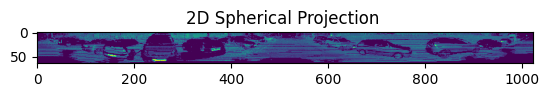

In [80]:
# Caminho para o diretório do dataset SemanticKITTI
sequence_path = 'A:/SemanticKITTI/dataset/sequences/13/'

# Número do frame desejado
frame_number = 3000

# Carrega os dados do dataset
point_cloud = load_semantic_kitti_data(sequence_path, frame_number)

# Projeção esférica dos pontos da nuvem
u, v, intensidade = spherical_projection(point_cloud)

# Criação da imagem (matriz)
image_matrix = create_ImageMatrix(u, v, intensidade)

# Visualização da projeção
visualize_spherical_projection(image_matrix)